# Using several classifiers and tuning parameters - Parameters grid
[From official `scikit-learn` documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html)

Adapted by Claudio Sartori

Example of usage of the ***model selection*** features of `scikit-learn` and comparison of several classification methods.
1. import a sample dataset 
1. split the dataset into two parts: train and test
    - the *train* part will be used for training and validation (i.e. for *development*)
    - the *test* part will be used for test (i.e. for *evaluation*)
    - the fraction of test data will be _ts_ (a value of your choice between 0.2 and 0.5)
1. the function `GridSearchCV` iterates a cross validation experiment to train and test a model with different combinations of paramater values
    - for each parameter we set a list of values to test, the function will generate all the combinations
    - we choose a *score function* which will be used for the optimization
        - e.g. `accuracy_score`, `precision_score`, `cohen_kappa_score`, `f1_score`, see this [page](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) for reference
    - the output is a dictionary containing 
        - the set of parameters which maximize the score 
        - the test scores
1. prepare the parameters for the grid
    - it is a list of dictionaries
1. set the parameters by cross validation and the *score functions* to choose from
1. Loop on scores and, for each score, loop on the model labels (see details below)

In [1]:
"""
http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
@author: scikit-learn.org and Claudio Sartori
"""
import warnings
warnings.filterwarnings('ignore') # uncomment this line to suppress warnings

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt
print(__doc__) # print information included in the triple quotes at the beginning

# Loading a standard dataset
#dataset = datasets.load_digits()
# dataset = datasets.fetch_olivetti_faces() # 40 classes!
# dataset = datasets.fetch_covtype()        # 581012 examples	 54 features 
# dataset = datasets.load_iris()    # 150 examples -- 4 features -- 3 classes
dataset = datasets.load_wine()      # 178 examples -- 13 features -- 3 classes
# dataset = datasets.load_breast_cancer() # binary


http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
@author: scikit-learn.org and Claudio Sartori



In [2]:

def print_results(model):
    print("Best parameters set found on train set:")
    print()
    # if best is linear there is no gamma parameter
    print(model.best_params_)
    print()
    print("Grid scores on train set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, std, params_tuple in zip(means, stds, params):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params_tuple))
    print()
    print("Detailed classification report for the best parameter set:")
    print()
    print("The model is trained on the full train set.")
    print("The scores are computed on the full test set.")
    print()
    Ytrue, Ypred = Ytest, model.predict(Xtest)
    print(classification_report(Ytrue, Ypred))
    print()

### Prepare the environment
The `dataset` module contains, among others, a few sample datasets.

See this [page](http://scikit-learn.org/stable/datasets/index.html) for reference

Prepare the data and the target in X and y. Set `ts`. Set the random state

In [3]:
X = dataset.data
Y = dataset.target
print("{:7} examples -- {} features -- {} classes".format(X.shape[0],X.shape[1], np.unique(Y).shape[0]))


    178 examples -- 13 features -- 3 classes


Split the dataset into the train and test parts

In [4]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y)
print('\n training samples dimension {}\n training labels dimension {}\n testing samples dimension {}\n testing labels dimension {}'.format(Xtrain.shape,Ytrain.shape,Xtest.shape,Ytest.shape))


 training samples dimension (133, 13)
 training labels dimension (133,)
 testing samples dimension (45, 13)
 testing labels dimension (45,)


The code below is intended to ease the remainder of the exercise

In [5]:
model_lbls = [
             'dt', 
             'nb', 
#              'lp', 
#              'svc', 
#              'knn',
            ]

# Set the parameters to be explored by the grid for each classifier
tuned_param_dt = [{'max_depth': list(range(1,20))}]
tuned_param_nb = [{'var_smoothing': [10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-07, 1e-8, 1e-9, 1e-10]}]
tuned_param_lp = [{'early_stopping': [True]}]
tuned_param_svc = [{'kernel': ['rbf'], 
                    'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100, 1000],
                    },
                    {'kernel': ['linear'],
                     'C': [1, 10, 100, 1000],                     
                    },
                   ]
tuned_param_knn =[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]

# set the models to be fitted specifying name, estimator and parameter structure
models = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(), 
           'param': tuned_param_dt,
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': tuned_param_nb
          },
    'lp': {'name': 'Linear Perceptron   ',
           'estimator': Perceptron(),
           'param': tuned_param_lp,
          },
    'svc':{'name': 'Support Vector      ',
           'estimator': SVC(), 
           'param': tuned_param_svc
          },
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': tuned_param_knn
        
    }
}

# scores to be explored
scores = [
          'precision', 
#           'recall',
         ]

### Try GridSearchCV with a DecisionTreeClassifier
Use `GridSearchCV` to get the best `max_depth` value for a `DecisionTreeClassifier` evaluating accuracy:
- Define the parameters to be tested and the range of values for each one
- Get a `GridSearchCV` instance for a `DecisionTreeClassifier`
- Fit the instance to the training data

**It's ok to get results that are different than the output**

In [6]:
DTree = DecisionTreeClassifier();

clf_dt = GridSearchCV(DTree, tuned_param_dt);

clf_dt.fit(Xtrain,Ytrain)


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                        13, 14, 15, 16, 17, 18, 19]}])

### The function below groups all the outputs
Write a `print_results` function that takes a fitted model and uses its attributes to inspect the results of the search with the parameter grid.

The attributes are:<br>
`model.best_params_`<br>
`model.cv_results_['mean_test_score']`<br>`
model.cv_results_['std_test_score']`<br>
`model.cv_results_['params']`

The report is generated by the `classification_report` function imported from `sklearn.metrics`, which takes as argument the true test labels and the predicted test labels.

The +/- in the results is obtained doubling the `std_test_score`. Mean and standard test scores are computed considering the various results on the cross-validation chunks.

The function will be used to print the results for each set of parameters in the last part of the exercise.

Use `print_results` to show the result of the tuning above.



In [7]:
clf_dt.best_params_

{'max_depth': 15}

In [8]:
clf_dt.cv_results_['mean_test_score']

array([0.60797721, 0.82649573, 0.90968661, 0.9022792 , 0.9022792 ,
       0.90940171, 0.87977208, 0.89430199, 0.87948718, 0.90940171,
       0.9017094 , 0.9022792 , 0.87948718, 0.85726496, 0.92450142,
       0.90911681, 0.89487179, 0.90940171, 0.92450142])

In [9]:
clf_dt.cv_results_['std_test_score']

array([0.08209579, 0.0783367 , 0.06038004, 0.07259984, 0.06020503,
       0.06958569, 0.07197102, 0.07323877, 0.07283424, 0.06958569,
       0.07779395, 0.08952218, 0.08001388, 0.09224084, 0.05300983,
       0.07059781, 0.06358065, 0.05653387, 0.05300983])

In [10]:
clf_dt.cv_results_['params']

[{'max_depth': 1},
 {'max_depth': 2},
 {'max_depth': 3},
 {'max_depth': 4},
 {'max_depth': 5},
 {'max_depth': 6},
 {'max_depth': 7},
 {'max_depth': 8},
 {'max_depth': 9},
 {'max_depth': 10},
 {'max_depth': 11},
 {'max_depth': 12},
 {'max_depth': 13},
 {'max_depth': 14},
 {'max_depth': 15},
 {'max_depth': 16},
 {'max_depth': 17},
 {'max_depth': 18},
 {'max_depth': 19}]

In [11]:
print_results(clf_dt)

Best parameters set found on train set:

{'max_depth': 15}

Grid scores on train set:

0.608 (+/-0.164) for {'max_depth': 1}
0.826 (+/-0.157) for {'max_depth': 2}
0.910 (+/-0.121) for {'max_depth': 3}
0.902 (+/-0.145) for {'max_depth': 4}
0.902 (+/-0.120) for {'max_depth': 5}
0.909 (+/-0.139) for {'max_depth': 6}
0.880 (+/-0.144) for {'max_depth': 7}
0.894 (+/-0.146) for {'max_depth': 8}
0.879 (+/-0.146) for {'max_depth': 9}
0.909 (+/-0.139) for {'max_depth': 10}
0.902 (+/-0.156) for {'max_depth': 11}
0.902 (+/-0.179) for {'max_depth': 12}
0.879 (+/-0.160) for {'max_depth': 13}
0.857 (+/-0.184) for {'max_depth': 14}
0.925 (+/-0.106) for {'max_depth': 15}
0.909 (+/-0.141) for {'max_depth': 16}
0.895 (+/-0.127) for {'max_depth': 17}
0.909 (+/-0.113) for {'max_depth': 18}
0.925 (+/-0.106) for {'max_depth': 19}

Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    re

### Loop on scores and, for each score, loop on the model labels
- iterate varying the score function
    1. iterate varying the classification model among Decision Tree, Naive Bayes, Linear Perceptron, Support Vector
        - activate the *grid search*
            1. the resulting model will be the best one according to the current score function
        - print the best parameter set and the results for each set of parameters using the above defined function
        - print the classification report
        - store the `.best score_` in a dictionary for a final report
    1. print the final report for the current *score funtion*


In [12]:
# Gaussian Naive Bayes
GNB = GaussianNB();

clf_nb = GridSearchCV(GNB, tuned_param_nb);

clf_nb.fit(Xtrain,Ytrain)

print_results(clf_nb)

Best parameters set found on train set:

{'var_smoothing': 1e-05}

Grid scores on train set:

0.533 (+/-0.119) for {'var_smoothing': 10}
0.654 (+/-0.150) for {'var_smoothing': 1}
0.691 (+/-0.115) for {'var_smoothing': 0.1}
0.699 (+/-0.132) for {'var_smoothing': 0.01}
0.768 (+/-0.148) for {'var_smoothing': 0.001}
0.895 (+/-0.143) for {'var_smoothing': 0.0001}
0.962 (+/-0.049) for {'var_smoothing': 1e-05}
0.962 (+/-0.096) for {'var_smoothing': 1e-06}
0.962 (+/-0.096) for {'var_smoothing': 1e-07}
0.962 (+/-0.096) for {'var_smoothing': 1e-08}
0.962 (+/-0.096) for {'var_smoothing': 1e-09}
0.962 (+/-0.096) for {'var_smoothing': 1e-10}

Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00     

In [13]:
# Linear Perceptron
LP = Perceptron();

clf_lp = GridSearchCV(LP, tuned_param_lp);

clf_lp.fit(Xtrain,Ytrain)

print_results(clf_lp)

Best parameters set found on train set:

{'early_stopping': True}

Grid scores on train set:

0.578 (+/-0.231) for {'early_stopping': True}

Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.82      0.93      0.87        15
           1       0.57      0.94      0.71        17
           2       0.00      0.00      0.00        13

    accuracy                           0.67        45
   macro avg       0.46      0.62      0.53        45
weighted avg       0.49      0.67      0.56        45




In [14]:
# Support Vector
SVM = SVC();

clf_svm = GridSearchCV(SVM, tuned_param_svc);

clf_svm.fit(Xtrain,Ytrain)

print_results(clf_svm)

Best parameters set found on train set:

{'C': 1, 'kernel': 'linear'}

Grid scores on train set:

0.624 (+/-0.227) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.662 (+/-0.125) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.676 (+/-0.221) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.722 (+/-0.184) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.699 (+/-0.207) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.797 (+/-0.209) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.699 (+/-0.207) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.827 (+/-0.174) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.947 (+/-0.060) for {'C': 1, 'kernel': 'linear'}
0.947 (+/-0.060) for {'C': 10, 'kernel': 'linear'}
0.947 (+/-0.060) for {'C': 100, 'kernel': 'linear'}
0.947 (+/-0.060) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision 

In [15]:
# Support Vector
KNN = KNeighborsClassifier();

clf_knn = GridSearchCV(KNN, tuned_param_knn);

clf_knn.fit(Xtrain,Ytrain)

print_results(clf_knn)

Best parameters set found on train set:

{'n_neighbors': 9}

Grid scores on train set:

0.653 (+/-0.266) for {'n_neighbors': 1}
0.631 (+/-0.180) for {'n_neighbors': 2}
0.646 (+/-0.256) for {'n_neighbors': 3}
0.661 (+/-0.230) for {'n_neighbors': 4}
0.639 (+/-0.161) for {'n_neighbors': 5}
0.616 (+/-0.174) for {'n_neighbors': 6}
0.639 (+/-0.138) for {'n_neighbors': 7}
0.647 (+/-0.139) for {'n_neighbors': 8}
0.693 (+/-0.101) for {'n_neighbors': 9}
0.655 (+/-0.178) for {'n_neighbors': 10}

Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        15
           1       0.86      0.71      0.77        17
           2       0.69      0.69      0.69        13

    accuracy                           0.80        45
   macro avg       0.79      0.80      0.79        45
weighted avg       0.80      0.80

{'dt': 0.9245014245014247, 'nb': 0.9621082621082622, 'lp': 0.5783475783475783, 'svc': 0.9472934472934474, 'knn': 0.6925925925925925}


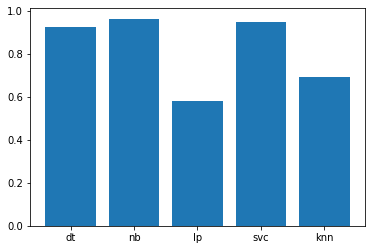

In [17]:
scores = {
    'dt': clf_dt.best_score_,
    'nb': clf_nb.best_score_,
    'lp': clf_lp.best_score_,
    'svc': clf_svm.best_score_,
    'knn': clf_knn.best_score_
}
names = list(scores.keys())
values = list(scores.values())
print(scores)
plt.bar(range(len(scores)), values, tick_label=names)
plt.show()